In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [368]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


## Define the cases

In [369]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test171"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d0918/Measure_MAT/Test171_E_d60_FC72_H127_FCL0960_R00.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'ConversionOffset', 'DefaultData', 'MP3Filtered', 'MP3RawValue', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test171
   - testType: E
   - repeatType: N
   - useTest: nan
   - fSampling: 50.0
   - calibrationFile: Test171
   - depthAtWM: 0.601
   - depthAtMPL: 0.568
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod: nan
   - focusingLocation: 9.6
   - remarks: Shagun
=== End of Test Properties ===



In [370]:
testName2 = "Test172"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d0918/Measure_MAT/Test172_E_d60_FC72_H127_FCL0960_R01.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'ConversionOffset', 'DefaultData', 'MP3Filtered', 'MP3RawValue', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test172
   - testType: E
   - repeatType: R1
   - useTest: nan
   - fSampling: 50.0
   - calibrationFile: Test172
   - depthAtWM: 0.601
   - depthAtMPL: 0.568
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod: nan
   - focusingLocation: 9.6
   - remarks: nan
=== End of Test Properties ===



## Extract Default Dataset and Set Tare

In [371]:
ds1 = loaded_mat1["DefaultData"]
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 5
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3RawValue'}
{'reference': 'MP3RawValue'}


## Shift time coord to overlap signals

In [372]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

In [ ]:
ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=20, tmax=80)

# Shift ds2 time to align max of WG01
# Can change to any other probe as needed
tShift = ds2_max_idxtime['WG01'].values - ds1_max_idxtime['WG01'].values

ds2 = ds2.assign_coords(Time=ds2['Time'] - tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

Shifting ds2 by -6.341799999999999


## Plot signals

### WM Probe

In [374]:
# xmin = 0
# xmax = 50


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label="DS1 WM")
# ds2['WM'].plot(linestyle='-', label="DS2 WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

### WG01 - WG03

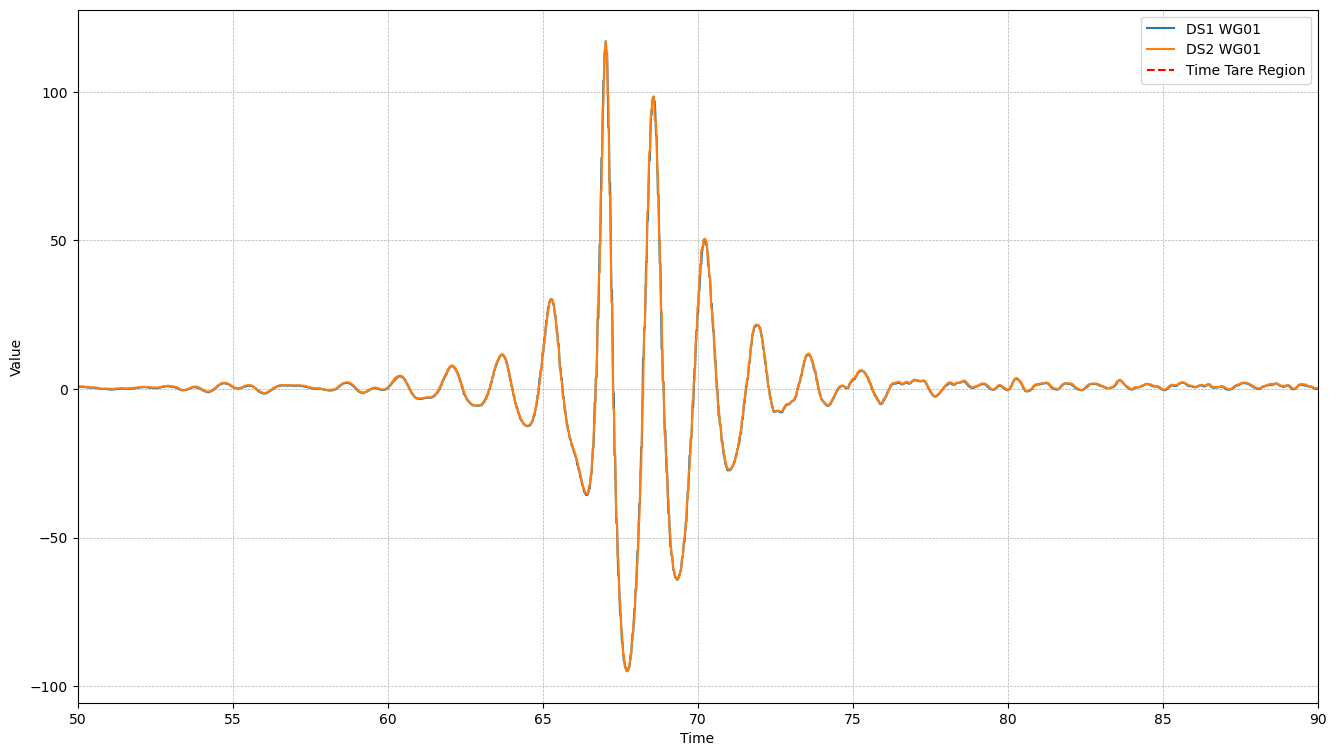

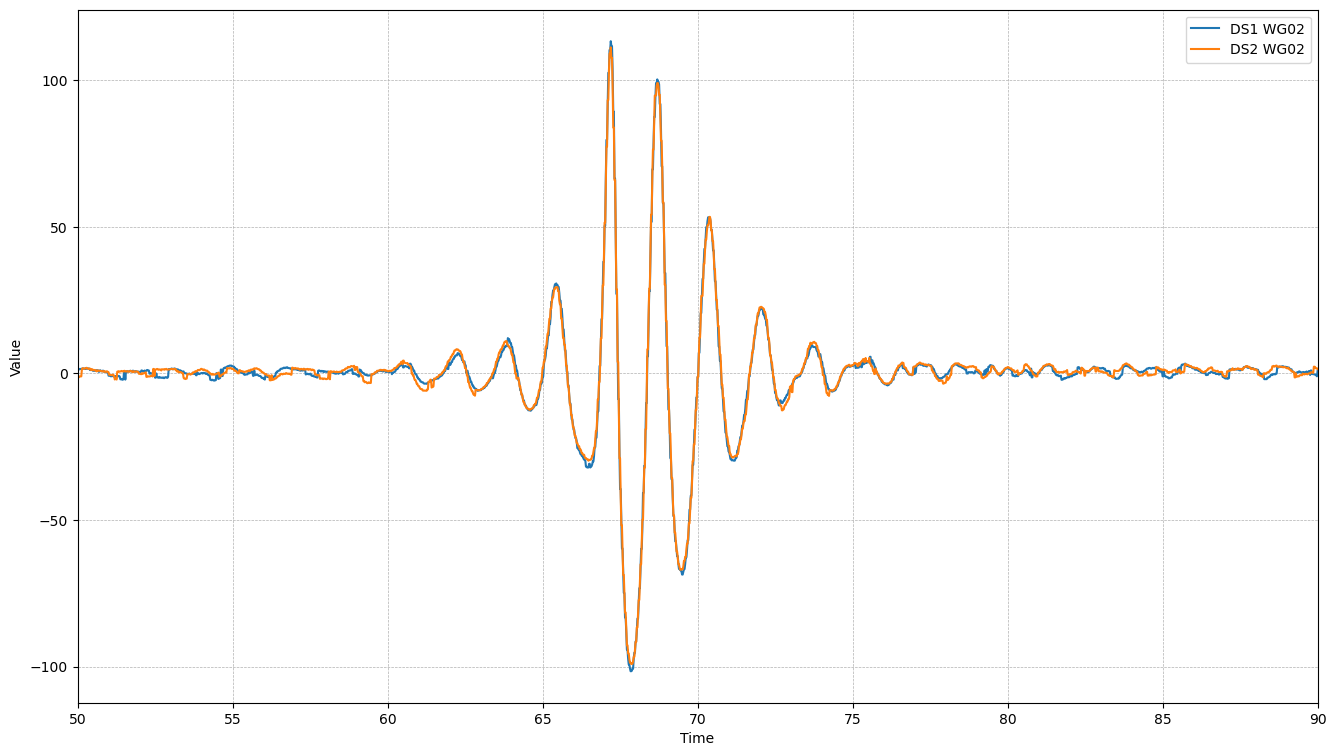

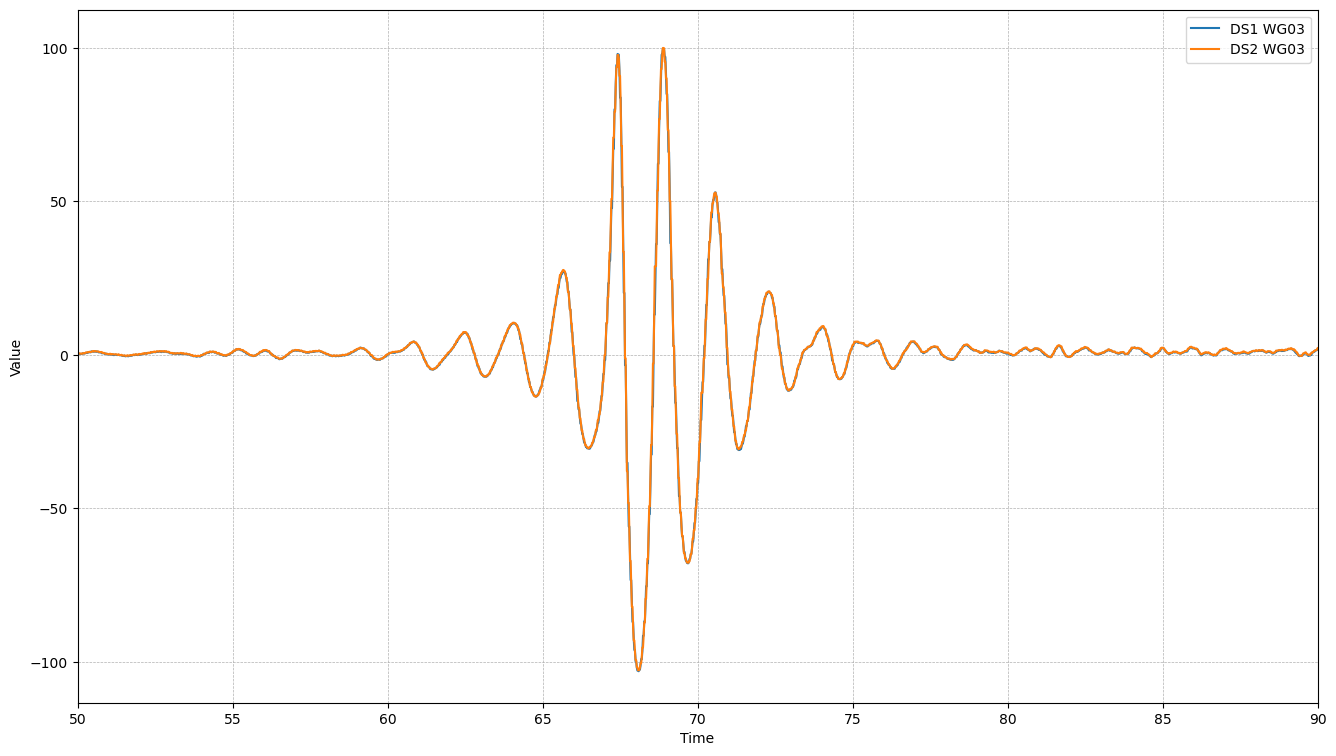

In [375]:
xmin = 50
xmax = 90

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label="DS1 WG01")
ds2['WG01'].plot(linestyle='-', label="DS2 WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG02'].plot(linestyle='-', label="DS1 WG02")
ds2['WG02'].plot(linestyle='-', label="DS2 WG02")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG03'].plot(linestyle='-', label="DS1 WG03")
ds2['WG03'].plot(linestyle='-', label="DS2 WG03")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG04 - WG06

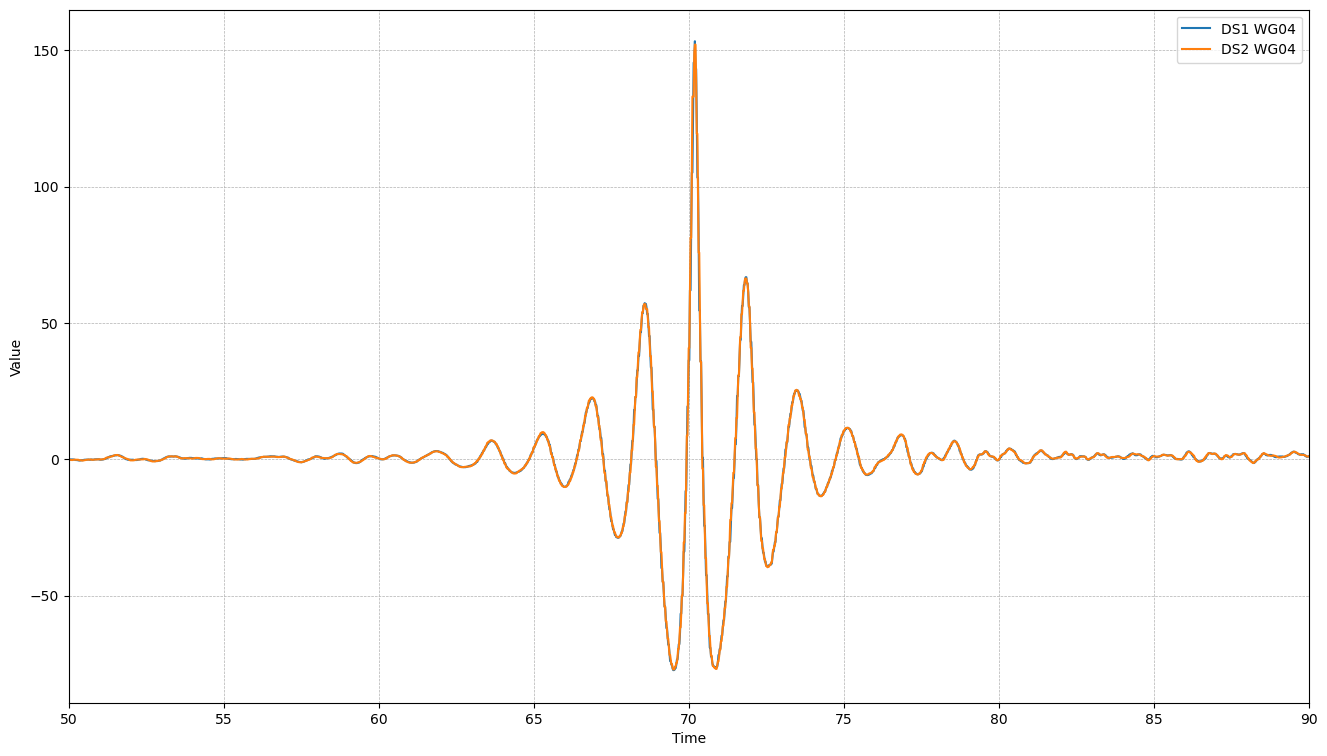

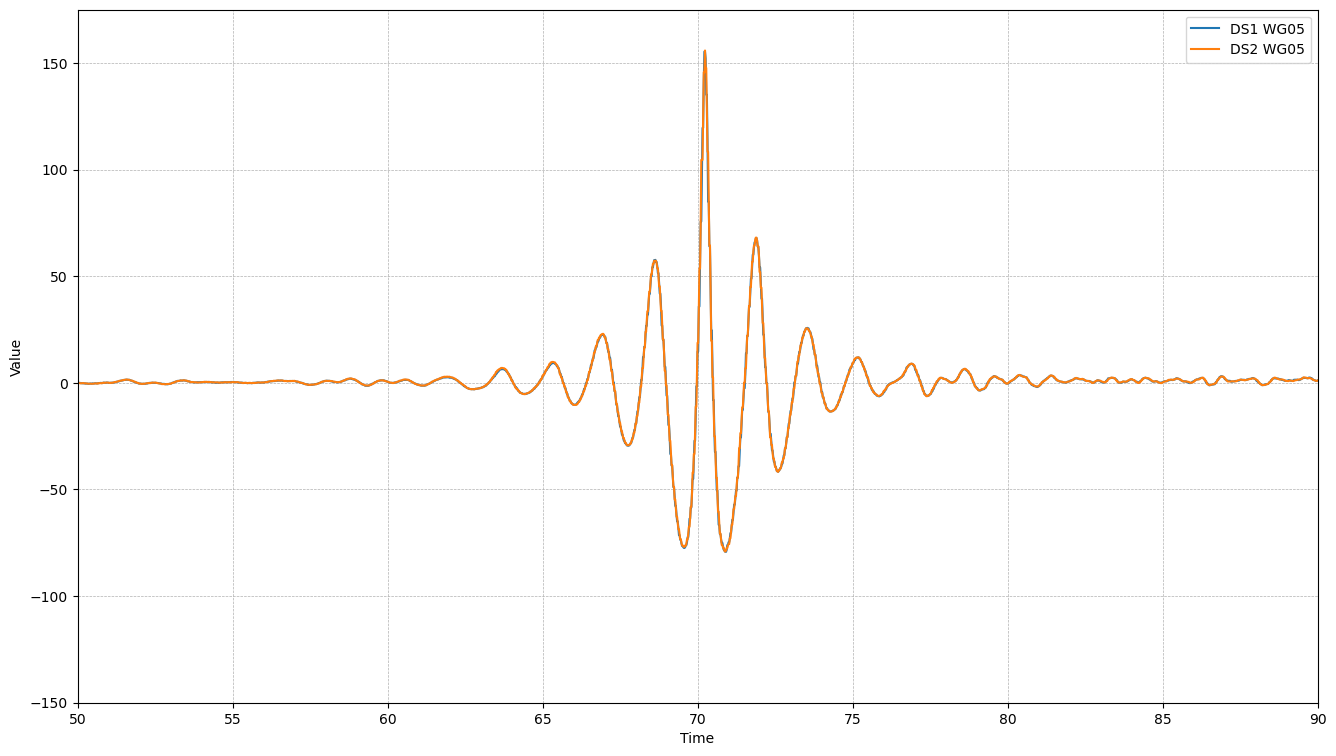

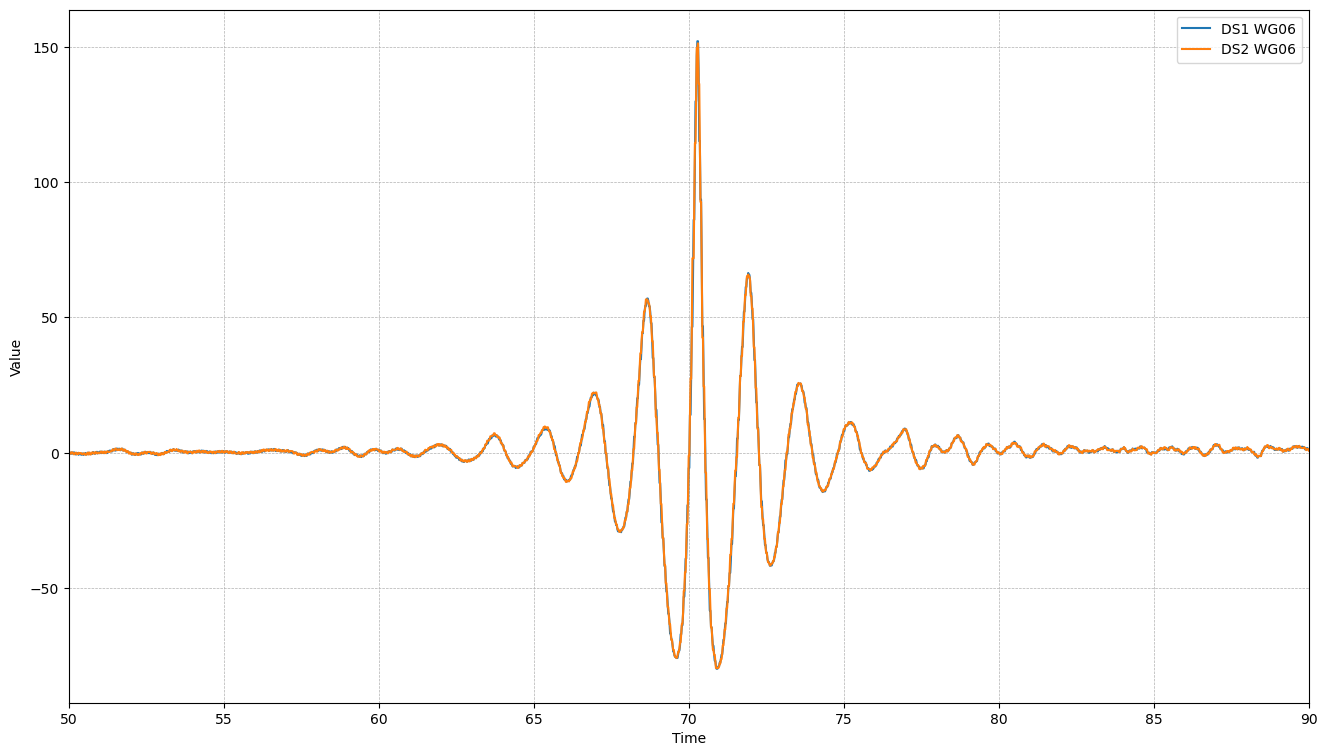

In [376]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG04'].plot(linestyle='-', label="DS1 WG04")
ds2['WG04'].plot(linestyle='-', label="DS2 WG04")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG05'].plot(linestyle='-', label="DS1 WG05")
ds2['WG05'].plot(linestyle='-', label="DS2 WG05")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
plt.ylim(-150, 175)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG06'].plot(linestyle='-', label="DS1 WG06")
ds2['WG06'].plot(linestyle='-', label="DS2 WG06")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG07 - WG09

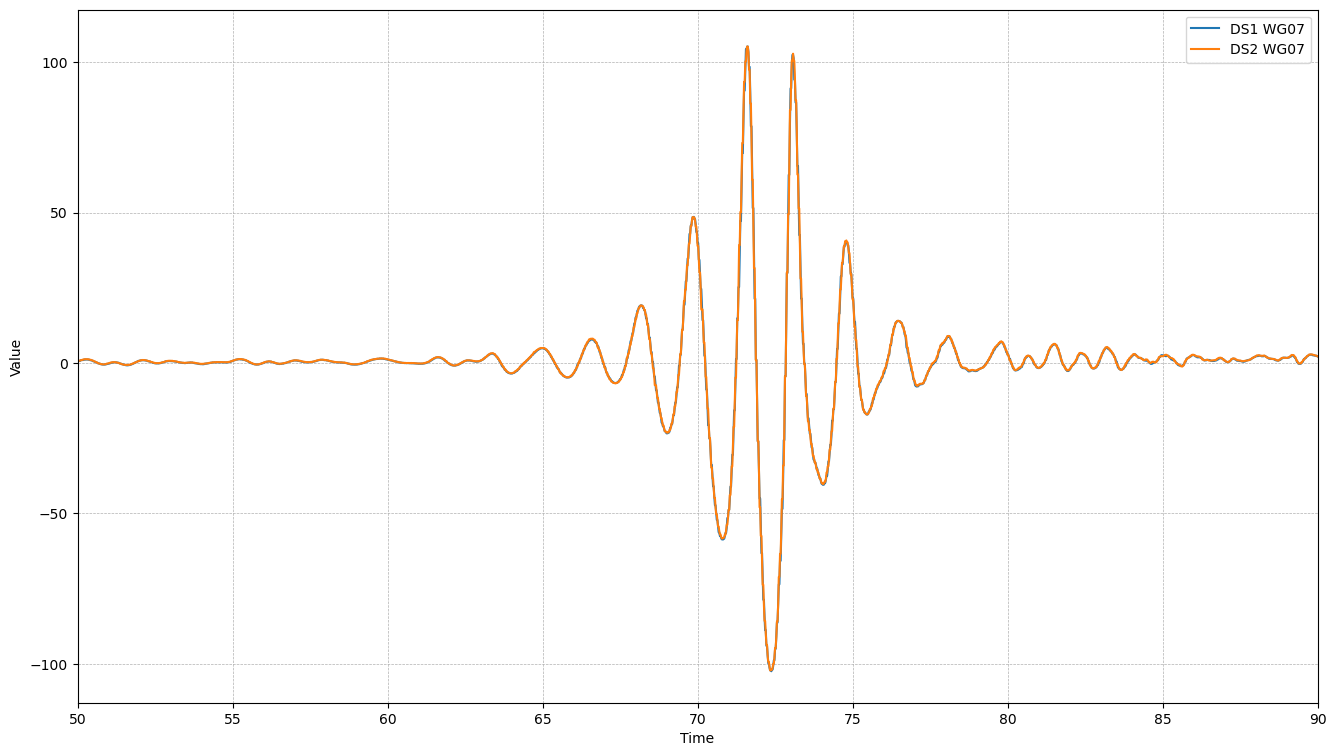

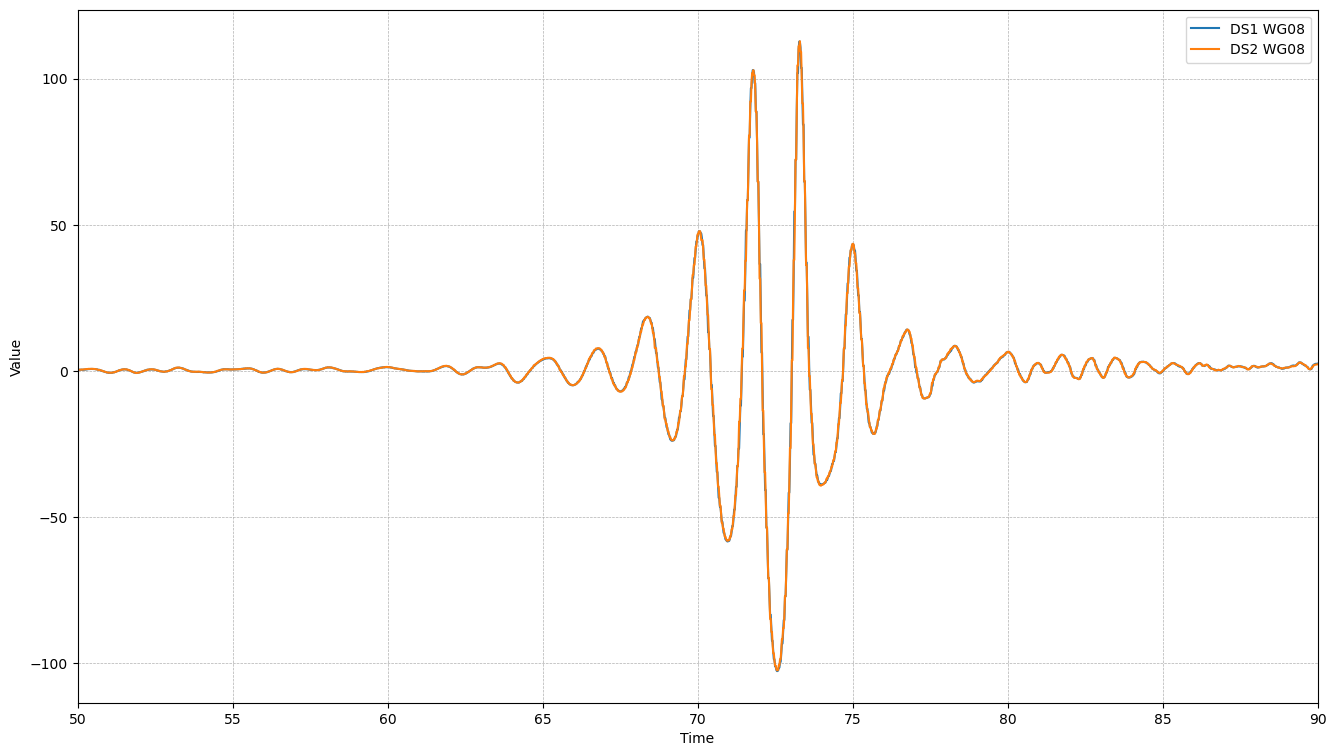

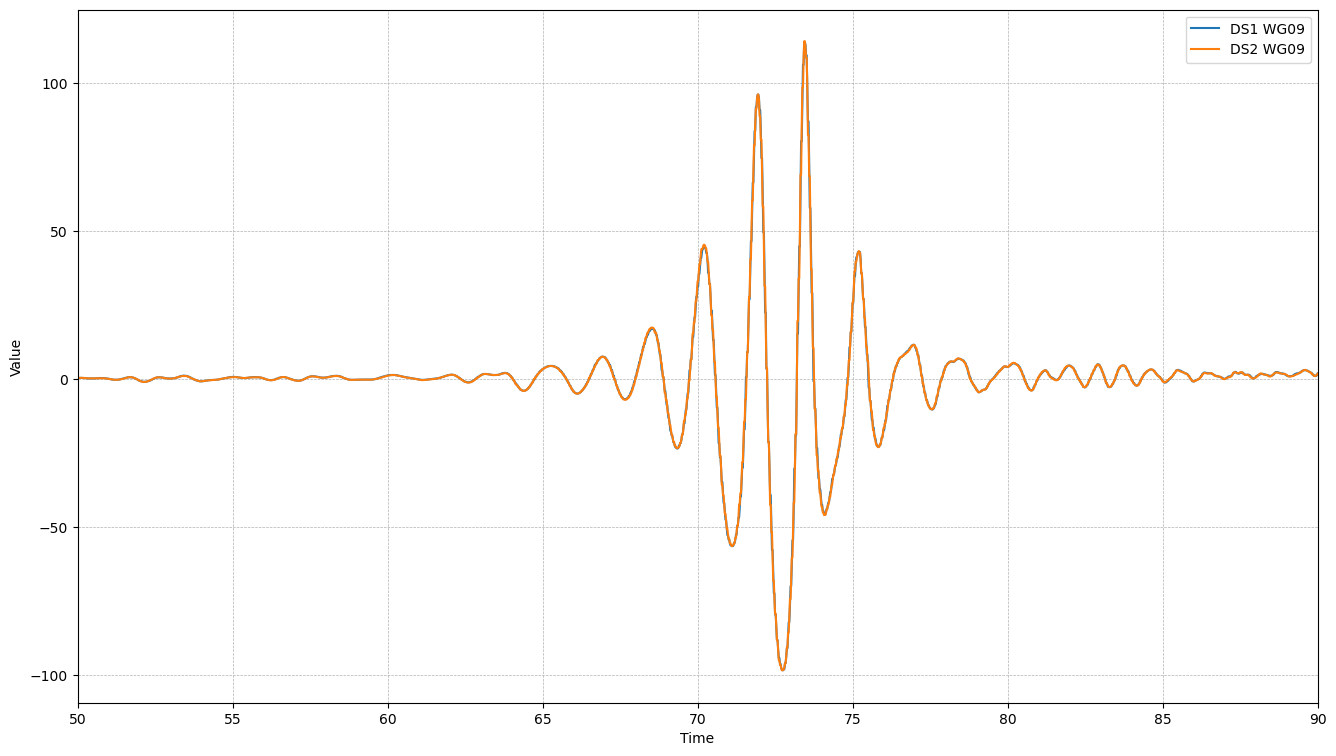

In [377]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG07'].plot(linestyle='-', label="DS1 WG07")
ds2['WG07'].plot(linestyle='-', label="DS2 WG07")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG08'].plot(linestyle='-', label="DS1 WG08")
ds2['WG08'].plot(linestyle='-', label="DS2 WG08")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG09'].plot(linestyle='-', label="DS1 WG09")
ds2['WG09'].plot(linestyle='-', label="DS2 WG09")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

## Find maxima

In [ ]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [379]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

print("DS1 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut)
print()

print("DS2 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut)  

DS1 Signal Min/Max in selected time range:
Signal: WG01   Max Value: 117.01545600840336 at : 67.0414   Min Value: -94.91874399159663 at : 67.7214
Signal: WG02   Max Value: 113.33835844537816 at : 67.2014   Min Value: -101.58304155462184 at : 67.8414
Signal: WG03   Max Value: 99.56977970588235 at : 68.8814   Min Value: -103.09122029411765 at : 68.1014
Signal: WG04   Max Value: 153.3278605882353 at : 70.2014   Min Value: -77.3108394117647 at : 69.5014
Signal: WG05   Max Value: 155.35351663865546 at : 70.2214   Min Value: -79.20508336134453 at : 70.9014
Signal: WG06   Max Value: 152.08786407563022 at : 70.2814   Min Value: -79.82573592436975 at : 70.9014
Signal: WG07   Max Value: 105.18208852941176 at : 71.6014   Min Value: -102.47041147058825 at : 72.3814
Signal: WG08   Max Value: 112.67233420168068 at : 73.2814   Min Value: -102.59766579831931 at : 72.5614
Signal: WG09   Max Value: 113.89587100840336 at : 73.4414   Min Value: -98.35362899159664 at : 72.7614
Signal: LED-chan100   Max Val

## Plot Spec

In [380]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 2000
Least count Hz = 0.025
Max Freq (Half band) Hz = 25.0
Sample Len = 2000
Least count Hz = 0.025
Max Freq (Half band) Hz = 25.0


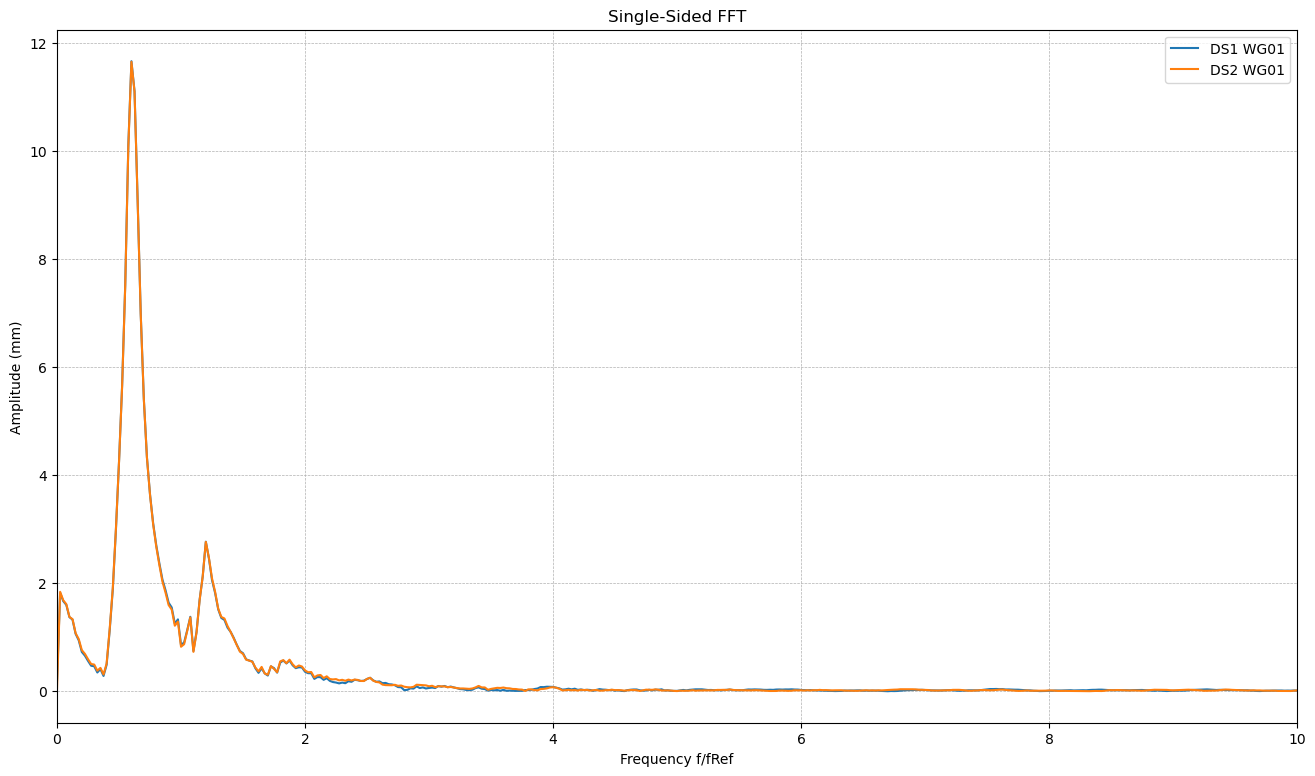

In [382]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

fSampling1 = loaded_mat1['TestProperties']['fSampling']
fSampling2 = loaded_mat2['TestProperties']['fSampling']

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, "DS1 WG01")
# getSpec(ds1_cut['WG05'], fSampling1, ax, xlim, "DS1 WG05")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, "DS1 WG07")
getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, "DS2 WG01")

pass